(weibull_aft)=

# Reparameterizing the Weibull Accelerated Failure Time Model

:::{post} January 17, 2023
:tags: censored, survival analysis, weibull
:category: intermediate, how-to
:author: Junpeng Lao, George Ho, Chris Fonnesbeck
:::

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.18.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Dataset

The {ref}`previous example notebook on Bayesian parametric survival analysis <bayes_param_survival_pymc3>` introduced two different accelerated failure time (AFT) models: Weibull and log-linear. In this notebook, we present three different parameterizations of the Weibull AFT model.

The data set we'll use is the `flchain` R data set, which comes from a medical study investigating the effect of serum free light chain (FLC) on lifespan. Read the full documentation of the data by running:

`print(sm.datasets.get_rdataset(package='survival', dataname='flchain').__doc__)`.

In [3]:
# Fetch and clean data
data = (
    sm.datasets.get_rdataset(package="survival", dataname="flchain")
    .data.sample(500)  # Limit ourselves to 500 observations
    .reset_index(drop=True)
)

In [4]:
y = data.futime.values
censored = ~data["death"].values.astype(bool)

In [5]:
y[:5]

array([ 975, 2272,  138, 4262, 4928])

In [6]:
censored[:5]

array([False,  True, False,  True,  True])

## Using `pm.Potential`

We have an unique problem when modelling censored data. Strictly speaking, we don't have any _data_ for censored values: we only know the _number_ of values that were censored. How can we include this information in our model?

One way do this is by making use of `pm.Potential`. The [PyMC2 docs](https://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class) explain its usage very well. Essentially, declaring `pm.Potential('x', logp)` will add `logp` to the log-likelihood of the model.

## Parameterization 1

This parameterization is an intuitive, straightforward parameterization of the Weibull survival function. This is probably the first parameterization to come to one's mind.

In [7]:
def weibull_lccdf(x, alpha, beta):
    """Log complementary cdf of Weibull distribution."""
    return -((x / beta) ** alpha)

In [8]:
with pm.Model() as model_1:
    alpha_sd = 10.0

    mu = pm.Normal("mu", mu=0, sigma=100)
    alpha_raw = pm.Normal("a0", mu=0, sigma=0.1)
    alpha = pm.Deterministic("alpha", pt.exp(alpha_sd * alpha_raw))
    beta = pm.Deterministic("beta", pt.exp(mu / alpha))

    y_obs = pm.Weibull("y_obs", alpha=alpha, beta=beta, observed=y[~censored])
    y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], alpha, beta))

In [9]:
with model_1:
    # Change init to avoid divergences
    data_1 = pm.sample(target_accept=0.9, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, a0]


/Users/roberto.corti/.local/share/virtualenvs/pymc-examples-nxyh3zmD/lib/python3.10/site-packages/rich/live.py:231:
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

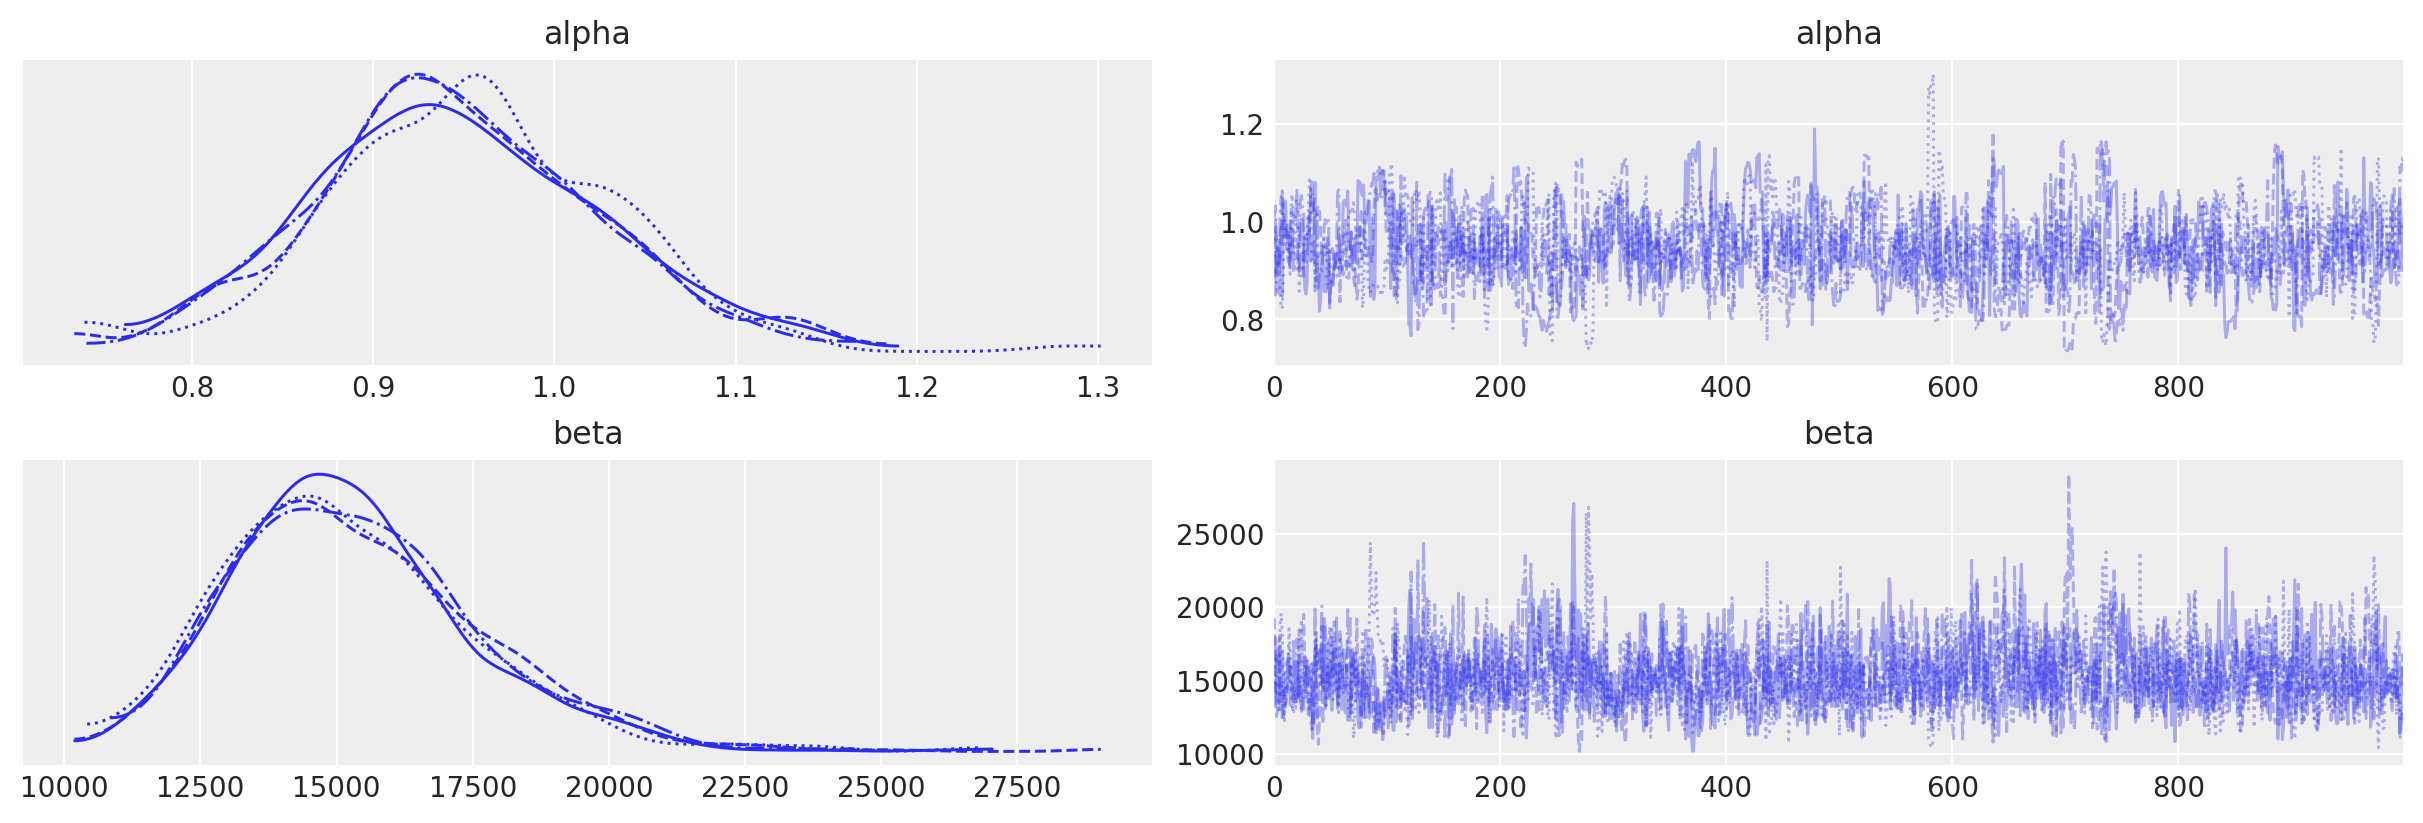

In [10]:
az.plot_trace(data_1, var_names=["alpha", "beta"])

In [11]:
az.summary(data_1, var_names=["alpha", "beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.95,0.08,0.79,1.09,0.00,0.0,715.95,617.68,1.01
beta,15301.45,2253.33,11412.28,19586.27,67.51,48.5,1163.87,1446.87,1.00


## Parameterization 2

Note that, confusingly, `alpha` is now called `r`, and `alpha` denotes a prior; we maintain this notation to stay faithful to the original implementation in Stan. In this parameterization, we still model the same parameters `alpha` (now `r`) and `beta`.

For more information, see [this Stan example model](https://github.com/stan-dev/example-models/blob/5e9c5055dcea78ad756a6fb9b3ff9a77a0a4c22b/bugs_examples/vol1/kidney/kidney.stan) and [the corresponding documentation](https://www.mrc-bsu.cam.ac.uk/wp-content/uploads/WinBUGS_Vol1.pdf).

In [12]:
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    r = pm.Gamma("r", alpha=1, beta=0.001, initval=0.25)
    beta = pm.Deterministic("beta", pt.exp(-alpha / r))

    y_obs = pm.Weibull("y_obs", alpha=r, beta=beta, observed=y[~censored])
    y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], r, beta))

In [13]:
with model_2:
    # Increase target_accept to avoid divergences
    data_2 = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, r]


/Users/roberto.corti/.local/share/virtualenvs/pymc-examples-nxyh3zmD/lib/python3.10/site-packages/rich/live.py:231:
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

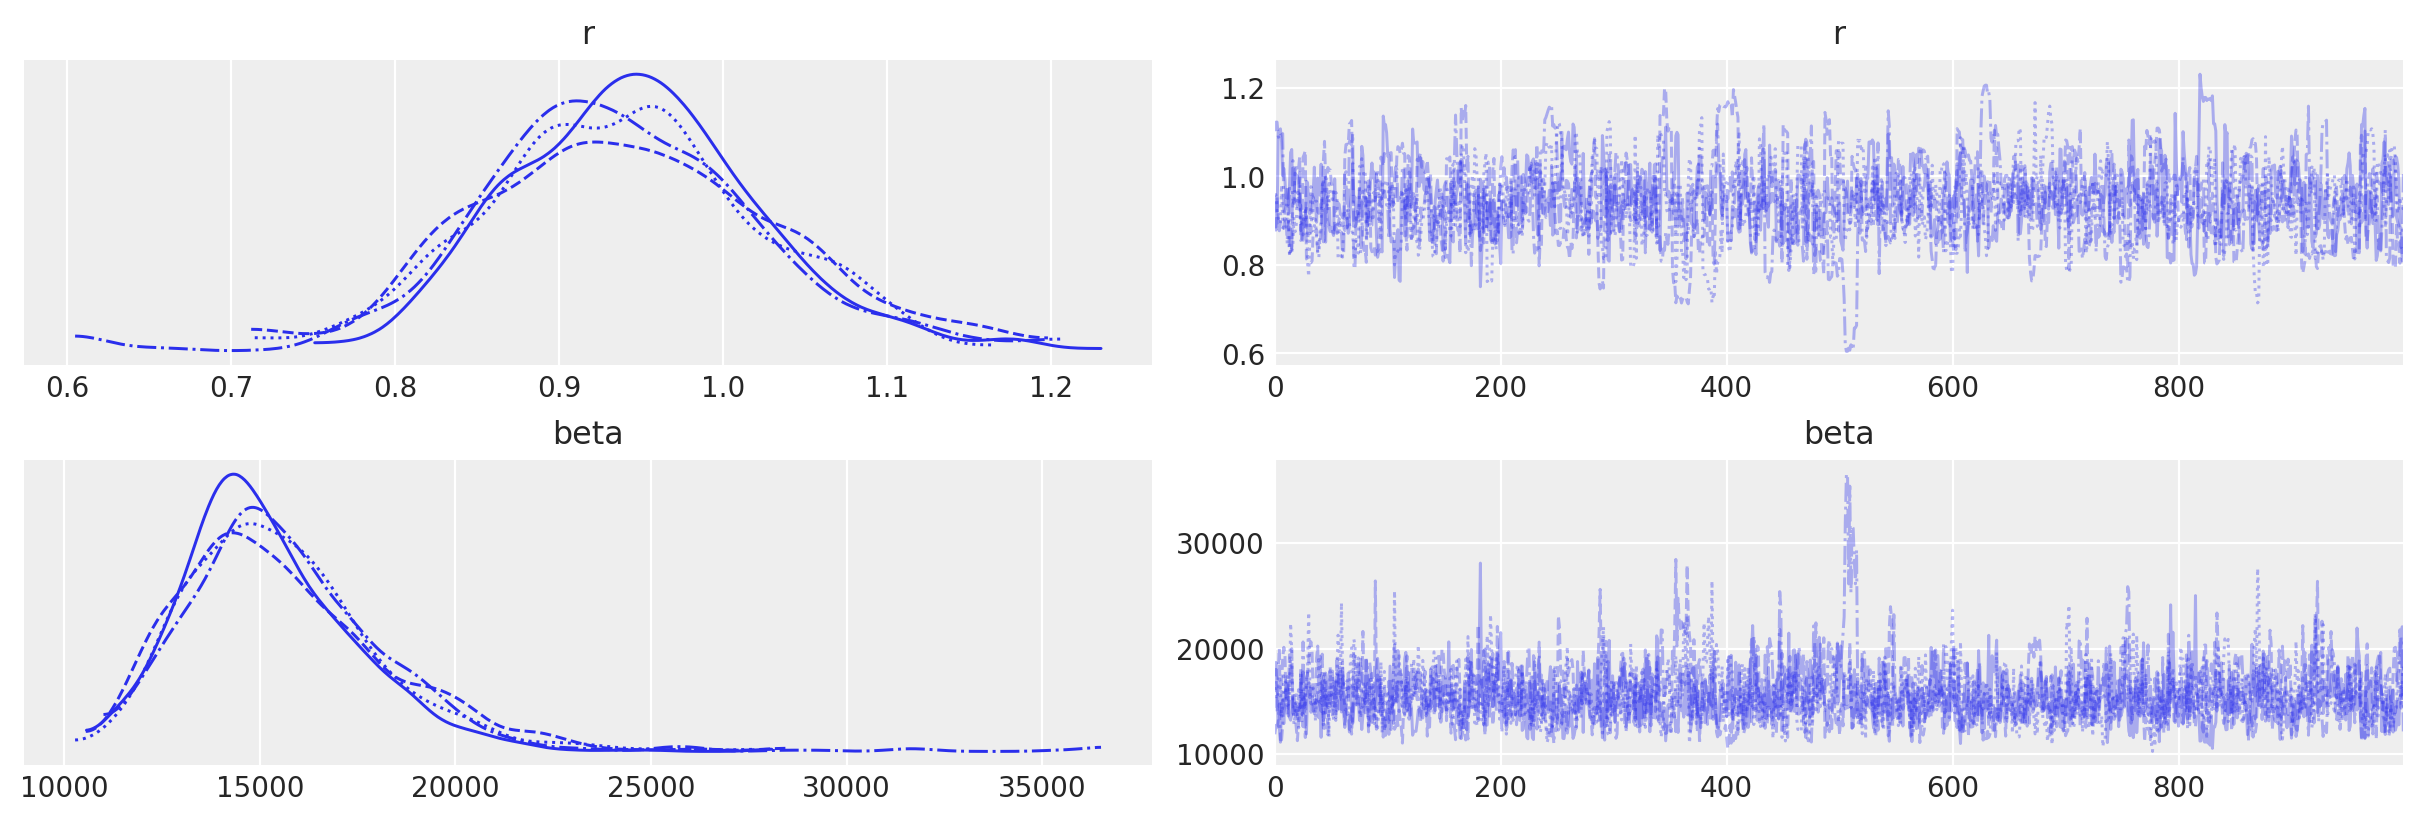

In [14]:
az.plot_trace(data_2, var_names=["r", "beta"])

In [15]:
az.summary(data_2, var_names=["r", "beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.94,0.08,0.79,1.11,0.00,0.00,599.1,562.34,1.01
beta,15523.25,2538.64,11551.33,20194.18,94.01,70.44,870.6,1073.58,1.00


## Parameterization 3

In this parameterization, we model the log-linear error distribution with a Gumbel distribution instead of modelling the survival function directly. For more information, see [this blog post](http://austinrochford.com/posts/2017-10-02-bayes-param-survival.html).

In [16]:
logtime = np.log(y)


def gumbel_sf(y, mu, sigma):
    """Gumbel survival function."""
    return 1.0 - pt.exp(-pt.exp(-(y - mu) / sigma))

In [17]:
with pm.Model() as model_3:
    s = pm.HalfNormal("s", tau=5.0)
    gamma = pm.Normal("gamma", mu=0, sigma=5)

    y_obs = pm.Gumbel("y_obs", mu=gamma, beta=s, observed=logtime[~censored])
    y_cens = pm.Potential("y_cens", gumbel_sf(y=logtime[censored], mu=gamma, sigma=s))

In [18]:
with model_3:
    # Change init to avoid divergences
    data_3 = pm.sample(init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, gamma]


/Users/roberto.corti/.local/share/virtualenvs/pymc-examples-nxyh3zmD/lib/python3.10/site-packages/rich/live.py:231:
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 's'}>, <Axes: title={'center': 's'}>]],
      dtype=object)

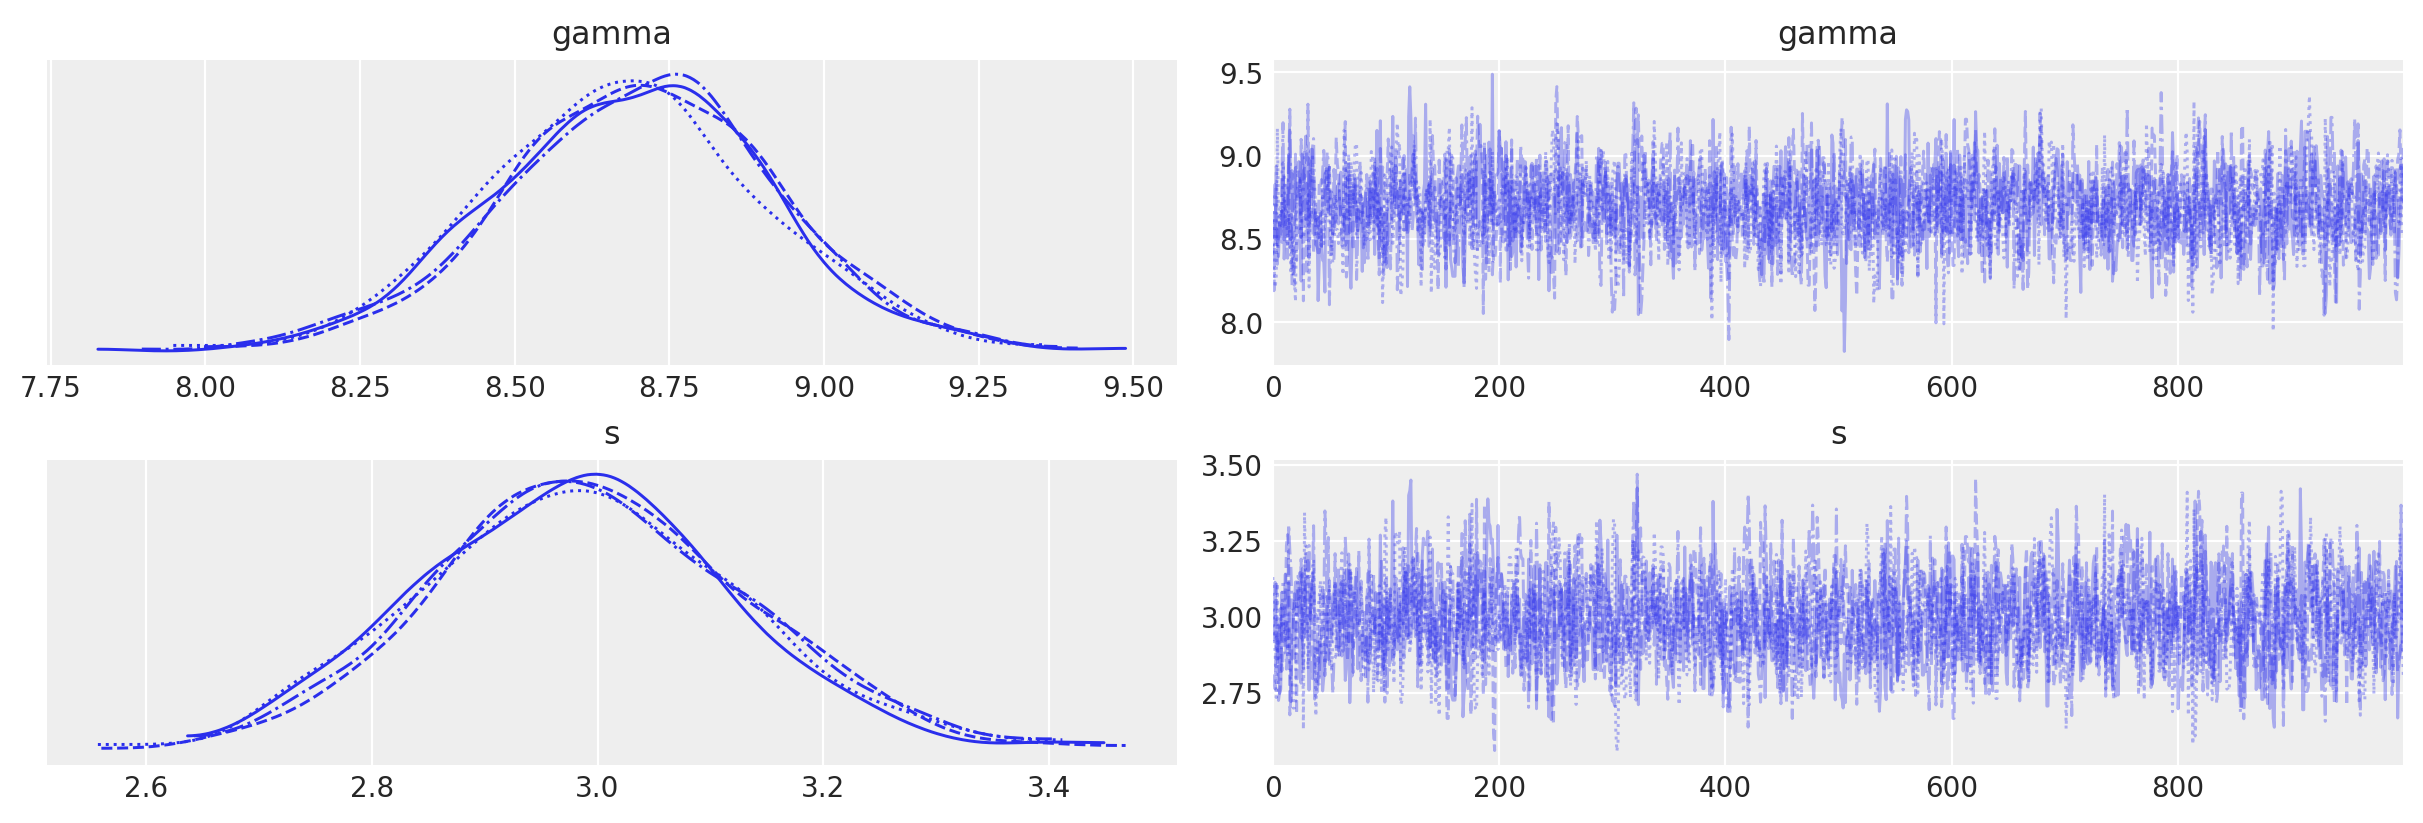

In [19]:
az.plot_trace(data_3)

In [20]:
az.summary(data_3, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,8.69,0.22,8.26,9.10,0.0,0.0,2151.12,2298.62,1.0
s,2.99,0.14,2.72,3.25,0.0,0.0,1994.83,2332.78,1.0


## Authors

- Originally collated by [Junpeng Lao](https://junpenglao.xyz/) on Apr 21, 2018. See original code [here](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/65447fdb431c78b15fbeaef51b8c059f46c9e8d6/PyMC3QnA/discourse_1107.ipynb).
- Authored and ported to Jupyter notebook by [George Ho](https://eigenfoo.xyz/) on Jul 15, 2018.
- Updated for compatibility with PyMC v5 by Chris Fonnesbeck on Jan 16, 2023.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Nov 24 2024

Python implementation: CPython
Python version       : 3.10.1
IPython version      : 8.29.0

statsmodels: 0.14.4
pymc       : 5.18.2
pytensor   : 2.26.3
arviz      : 0.20.0
numpy      : 1.26.4

Watermark: 2.5.0



:::{include} ../page_footer.md
:::